# Extracting subregions from a MUSE cube

I want to learn how to extract regions along the spatial and wavelength axes and manipulate them to do things continuum subtraction.

In [2]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))
cube.info()

[INFO] 3801 x 326 x 346 Cube (/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/ADP.2017-10-16T11_04_19.247.fits)
[INFO] .data(3801 x 326 x 346) (1e-20 erg / (Angstrom cm2 s)), .var(3801 x 326 x 346)
[INFO] center:(-72:10:31.853,00:59:02.986) size:(65.200",69.200") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:4599.94 max:9349.94 step:1.25 Angstrom


## Extracting wavelength slices

We make a summed spectrum of the entire field again, just like in the previous notebook.

In [4]:
sp0 = cube.sum(axis=(1, 2))

Now, we take a look at the region around the H alpha line. The `Spectrum.subspec` method allows us to use Å instead of pixels.

[None]

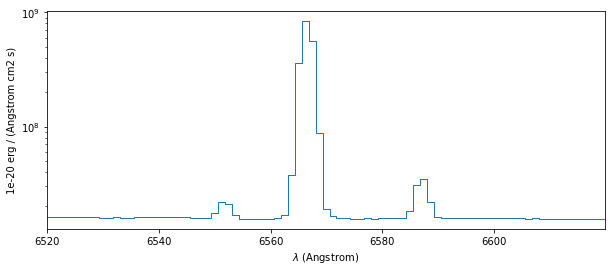

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(6520.0, 6620.0).plot()
ax.set(yscale="log")

This shows that a good range for extracting Ha would be 6560 to 6575 Å.  So, we just do a simple-minded sum of that range. For some reason, the equivalent of `Spectrum.subspec` for a `Cube` has a different name, `Cube.select_lambda`:

In [6]:
im_ha = cube.select_lambda(6560.0, 6575.0).sum(axis=0)

And we have a look at it:

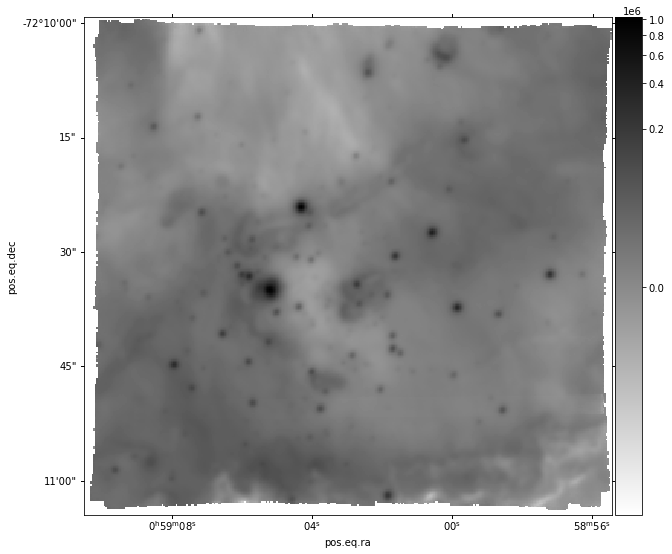

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha.plot(use_wcs=True, cmap="gray_r", scale="log", colorbar="v")

So, that looks good, but it includes the continuum.  A very simple-minded way of removing the continuum would just be to take an average value in line-free wavelength ranges.

We can use 6555-60 and 6575-80:

In [8]:
im_blue_cont = cube.select_lambda(6555.0, 6560.0).mean(axis=0)
im_red_cont = cube.select_lambda(6575.0, 6580.0).mean(axis=0)
im_mean_cont = (im_blue_cont + im_red_cont) / 2.0

So we have a map of the average continuum from the red and blue sides of the line, which we will now visualize:

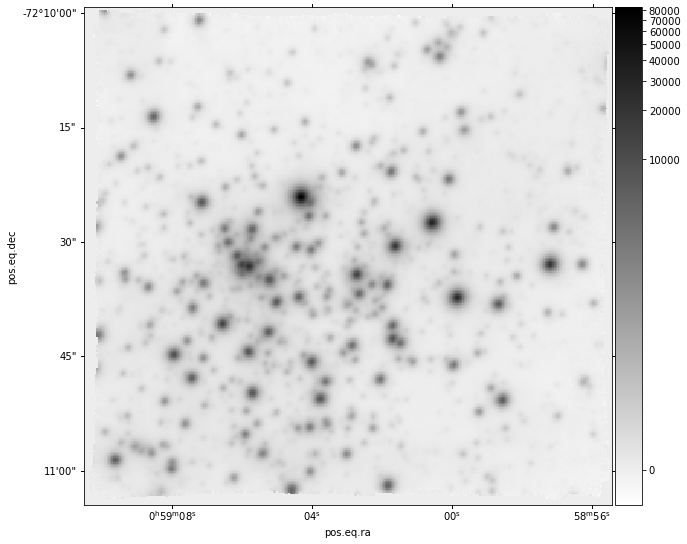

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
im_mean_cont.plot(use_wcs=True, cmap="gray_r", scale="log", colorbar="v")

Now I subtract the average continuum level before summing again to find the BG-subtracted line map. We have to do it this way because `im_mean_cont` still has the per-Å units since it is a mean, so we can't just subtract it from `im_ha`.

In [10]:
im_ha_bgsub = (cube.select_lambda(6560.0, 6575.0) - im_mean_cont).sum(axis=0)

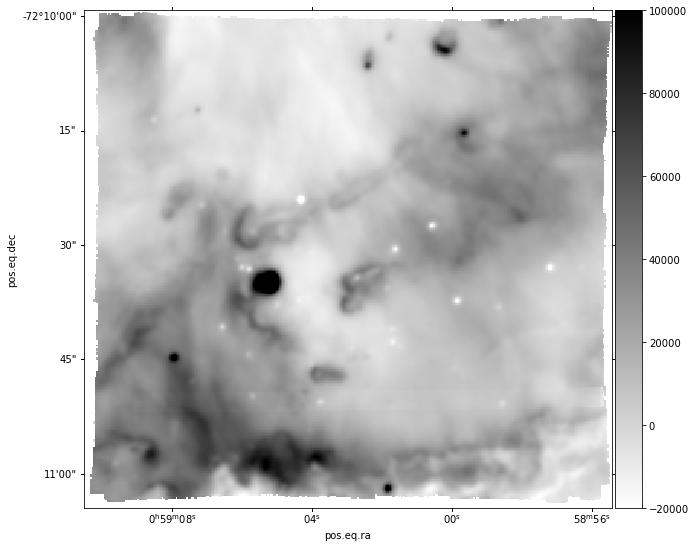

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha_bgsub.plot(
    use_wcs=True,
    vmin=-2.0e4,
    vmax=1.0e5,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)

So. now we can see beautiful details of the Hα emission. There are chains of globules and elephant-trunk structures that cross the nebula. These are physically quite large – about 2 arcsec, which is about 0.5 parsec.  The entire field is about 15 pc square.

The white dots are presumably from the underlying photospheric absorption from some of the stars.  Other stars are seen in emission.

Strangely, though, the brightnesses go negative

In [12]:
im_ha.data.min()

-23906.358207702637

In [13]:
im_mean_cont.data.min()

-52.58787977695465

In [14]:
im_ha_ew = (im_ha_bgsub - im_ha.data.min()) / (im_mean_cont - im_mean_cont.data.min())

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: divide by zero encountered in true_divide
  var /= (b_data ** 4)


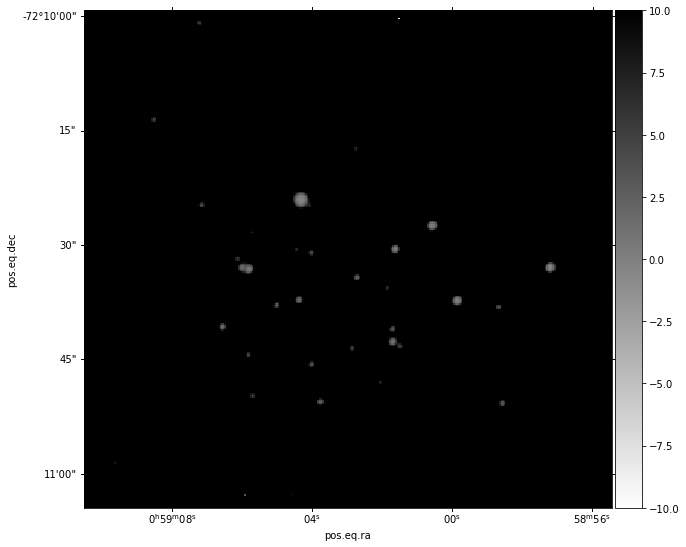

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha_ew.plot(
    vmin=-10.0,
    vmax=10.0,
    use_wcs=True,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)

 ## Extracting spatial regions

We will go back to the ha+continuum image and try and plot it without the stars

In [16]:
savemask = im_ha.mask
savemask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

We mask out the bright continuum sources using `mask_selection`

In [21]:
im_ha.mask_selection(np.where(im_mean_cont.data > 1000.0))

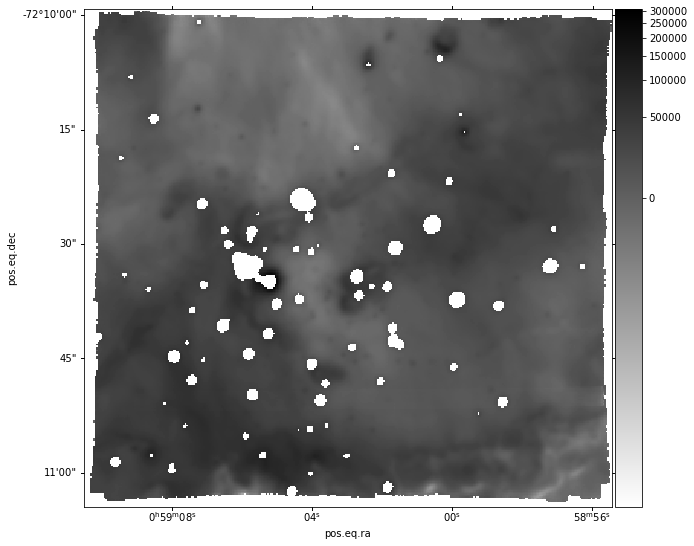

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha.plot(use_wcs=True, cmap="gray_r", scale="log", colorbar="v")

What this uses is an array of pixels, such as provided by `np.where`:

In [25]:
bright_cont_selection = np.where(im_mean_cont.data > 1000.0)
bright_cont_selection

(array([  7,   7,   7, ..., 318, 323, 323]),
 array([135, 136, 137, ...,  76,  13,  14]))

In [24]:
savecubemask = cube.mask

In [26]:
cube.mask_selection(bright_cont_selection)

IndexError: index 326 is out of bounds for axis 1 with size 326